In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from libsimplesn import SimpleSN
from uplot.tikz.pgfdata import to_pgfdata
from uplot.tikz.utils import segs_to_coords


sns.reset_orig()

In [23]:
VERSIONS = {
    (1_000, 'mphotoz'): 0, (1_000, 'specz'): 0, (1_000, 'photoz'): 0,
    (2_000, 'mphotoz'): 0, (2_000, 'specz'): 0, (2_000, 'photoz'): 0,
    (5_000, 'mphotoz'): 0, (5_000, 'specz'): 0, (5_000, 'photoz'): 0,
    (10_000, 'mphotoz'): 0, (10_000, 'specz'): 2, (10_000, 'photoz'): 0,
    (20_000, 'mphotoz'): 0, (20_000, 'specz'): 0, (20_000, 'photoz'): 0,
    (50_000, 'mphotoz'): 0, (50_000, 'specz'): 0, (50_000, 'photoz'): 0,
    (100_000, 'mphotoz'): 1, (100_000, 'specz'): 2, (100_000, 'photoz'): 0,
}

hdis_mc = SimpleSN('pantheon-g10').hdi_mc

hdis_nre = SimpleSN('pantheon-g10').hdi_nre
hdis_nre = pd.Series(
    {key[:-1]: val for key, val in hdis_nre.items() if key[-1].endswith(str(VERSIONS[key[:2]]))},
    name=hdis_nre.name
).rename_axis(hdis_mc.index.names)

hdis = pd.DataFrame({'mcmc': hdis_mc, 'nre': hdis_nre})

def annotate(data, **kwargs):
    plt.plot((1e3, 1e5), (1e-2, 1e-2 * ((1e5/1e3)**(-0.5))**2), 'k:', lw=0.5, zorder=-1)

## Areas

In [79]:
import shapely.geometry as sh

LEVELS = (0.1, 0.5, 0.68, 0.9, 0.95)

area = pd.Series({
    (method,) + key + (level,): sh.MultiPolygon([(c, []) for c in cs]).area
    for method, hdis_ in hdis.items()
    for key, hdi in hdis_.items() if not pd.isna(hdi)
    for level, cs in zip(LEVELS, plt.tricontour(*hdi, levels=LEVELS).allsegs)
}, name='area').rename_axis(('method', 'N', 'datatype', 'suffix', 'version', 'level')).xs(axis='index', level='suffix', key=0).loc[(slice(None), slice(None), ['mphotoz', 'specz'])]
plt.close()
area

method  N       datatype  version  level
mcmc    1000    mphotoz   0        0.10     0.009221
                                   0.50     0.059877
                                   0.68     0.094208
                                   0.90     0.176835
                                   0.95     0.216376
                                              ...   
nre     100000  specz     9        0.10     0.000018
                                   0.50     0.000115
                                   0.68     0.000183
                                   0.90     0.000361
                                   0.95     0.000472
Name: area, Length: 1400, dtype: float64

/usr/lib/python3.10/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  self._figure.tight_layout(*args, **kwargs)


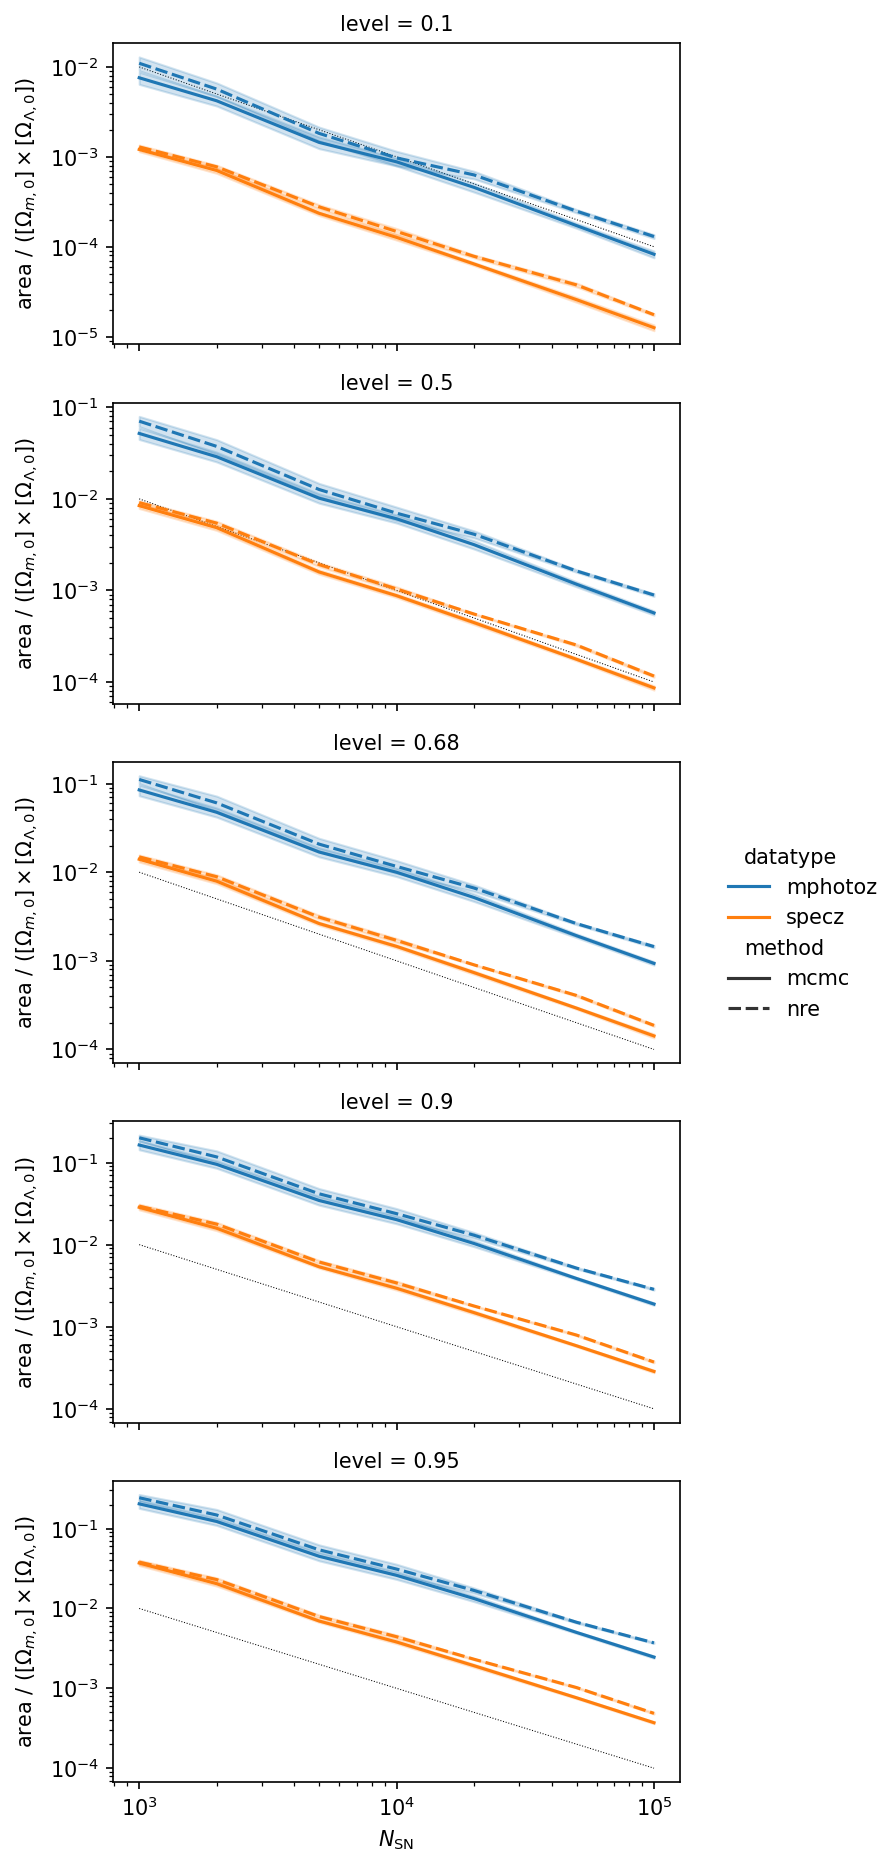

In [80]:
g = sns.relplot(
    data=area.reset_index(), x='N', y='area',
    hue='datatype', style='method', row='level',
    kind='line', ci='sd',
    height=2.5, aspect=2, facet_kws=dict(sharey='row', despine=False),
).map_dataframe(annotate).set(yscale='log', xscale='log').set_axis_labels('$N_{\mathrm{SN}}$', r'area / $([\Omega_{m, 0}] \times [\Omega_{\Lambda, 0}])$');

/usr/lib/python3.10/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  self._figure.tight_layout(*args, **kwargs)


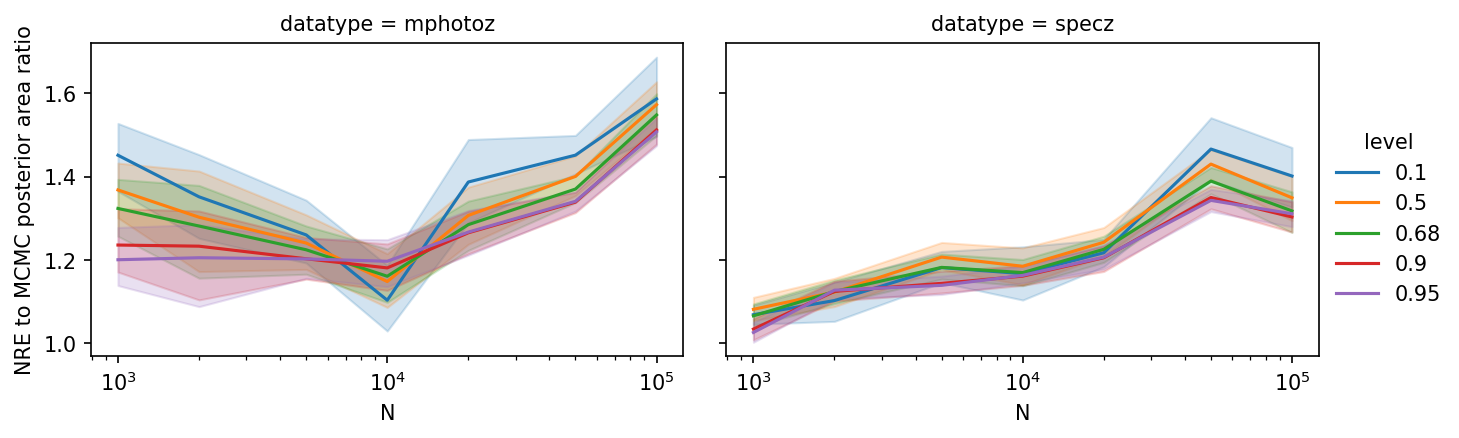

In [81]:
sns.relplot(
    data=(area['nre'] / area['mcmc']).rename('ratio').reset_index(), x='N', y='ratio',
    hue='level', col='datatype',
    palette='tab10',
    kind='line', height=3, aspect=1.5, facet_kws=dict(despine=False)
).set(xscale='log', ylabel='NRE to MCMC posterior area ratio');

#### Paris

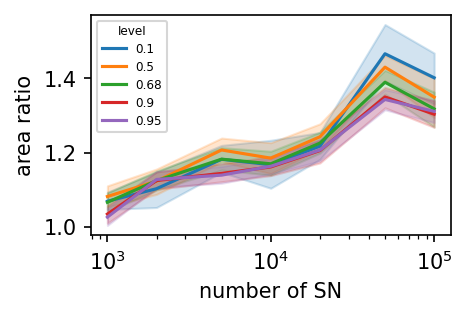

In [82]:
dta = area['nre'] / area['mcmc']
dta = dta[dta.index.get_level_values('datatype') == 'specz']
plt.figure(figsize=(3, 2))
ax = sns.lineplot(
    data=dta.rename('ratio').reset_index(), x='N', y='ratio',
    hue='level', palette='tab10'
)
ax.set_xscale('log')
ax.set_xlabel('number of SN')
ax.set_ylabel('area ratio')
ax.get_legend().remove()
ax.legend(title='level', fontsize='xx-small', title_fontsize='xx-small')

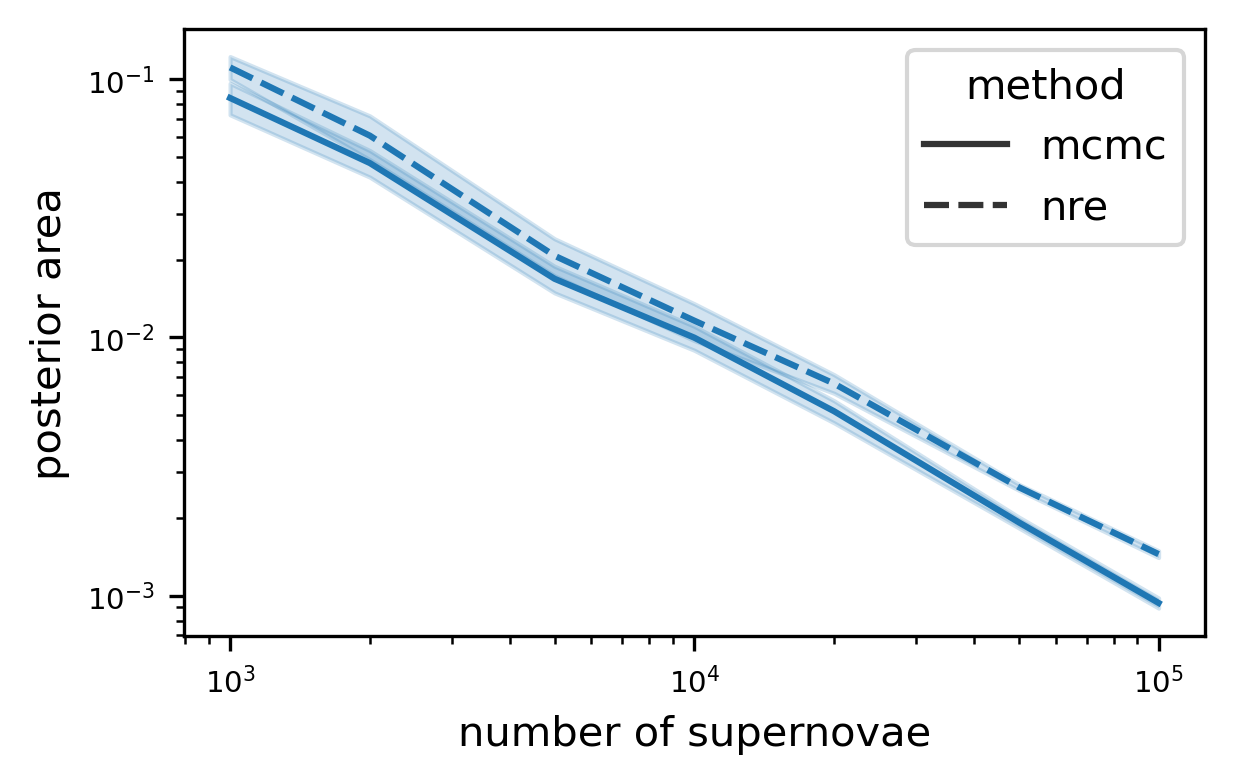

In [83]:
plt.figure(figsize=(4, 2.5), dpi=300)
ax = sns.lineplot(
    data=area[np.logical_and(
        area.index.get_level_values('level') == 0.68,
        area.index.get_level_values('datatype') == 'mphotoz'
    )].reset_index(), x='N', y='area',
    style='method',
    ci='sd',
)
ax.set(xscale='log', yscale='log', xlabel='number of supernovae', ylabel='posterior area')
ax.tick_params(labelsize=7)

#### TiKZ

In [87]:
dta = area.reset_index().groupby([n for n in area.index.names if n not in ('version',)])['area'].aggregate([np.mean, np.std])
dta = pd.concat({
    'mcmc': dta.loc['mcmc'], 'nre': dta.loc['nre'],
    'ratio': (area['nre'] / area['mcmc']).reset_index().groupby([n for n in area.index.names if n not in ('version', 'method')])['area'].aggregate([np.mean, np.std])
}, axis='columns')
dta.columns = dta.columns.to_flat_index()
dta = dta.rename(columns=' '.join)
dta.to_csv('paper/plotdata/areas.csv')
dta

mcmc mean      mcmc std  nre mean       nre std  \
N      datatype level                                                    
1000   mphotoz  0.10    0.007574  1.174892e-03  0.010985  1.912736e-03   
                0.50    0.051800  7.279373e-03  0.070552  9.027404e-03   
                0.68    0.084703  1.181290e-02  0.111244  1.129695e-02   
                0.90    0.163368  2.042365e-02  0.200023  1.567700e-02   
                0.95    0.203872  2.486401e-02  0.243233  2.387163e-02   
...                          ...           ...       ...           ...   
100000 specz    0.10    0.000013  9.268114e-07  0.000018  4.699627e-07   
                0.50    0.000086  4.640921e-06  0.000116  3.123820e-06   
                0.68    0.000142  7.374892e-06  0.000187  4.669619e-06   
                0.90    0.000285  1.034701e-05  0.000372  8.245528e-06   
                0.95    0.000371  1.082153e-05  0.000486  9.698571e-06   

                       ratio mean  ratio std  
N      datatype level                         
1000   mphotoz  0.10     1.451618   0.133890  
                0.50     1.368304   0.110405  
                0.68     1.323916   0.119006  
                0.90     1.236047   0.137302  
                0.95     1.200760   0.119535  
...                           ...        ...  
100000 specz    0.10     1.401736   0.115864  
                0.50     1.349463   0.091672  
                0.68     1.317945   0.083838  
                0.90     1.303409   0.060726  
                0.95     1.311093   0.052123  

[70 rows x 6 columns]

## MSEs

In [61]:
Om0, Ode0 = 0.3, 0.7


mses = pd.DataFrame({
    (method,) + key: {
        'detcov': np.linalg.det(np.cov(X.T, aweights=w)),
        'bias': np.linalg.norm(np.average(X, weights=w, axis=-2) - (Om0, Ode0), axis=-1),
        'mse': np.average(np.linalg.norm(X - (Om0, Ode0), axis=-1)**2, weights=w)
        # 'var': np.average((x - Om0)**2 + (y - Ode0)**2, weights=w)
    }
    for method, hdis_ in hdis.items()
    for key, hdi in hdis_.items() if not pd.isna(hdi)
    for hdi in [np.stack(hdi, -1)]
    for x, y, z in [hdi[np.argsort(hdi[..., -1])[::-1]].T]
    for X in [np.stack((x, y), -1)]
    for w in [-np.diff(z)] for w in [np.concatenate((w, (1-w.sum(),))[::-1])]
}).T.rename_axis(index=('method', 'N', 'datatype', 'suffix', 'version')).xs(axis='index', level='suffix', key=0).loc[(slice(None), slice(None), ['mphotoz', 'specz']), :]

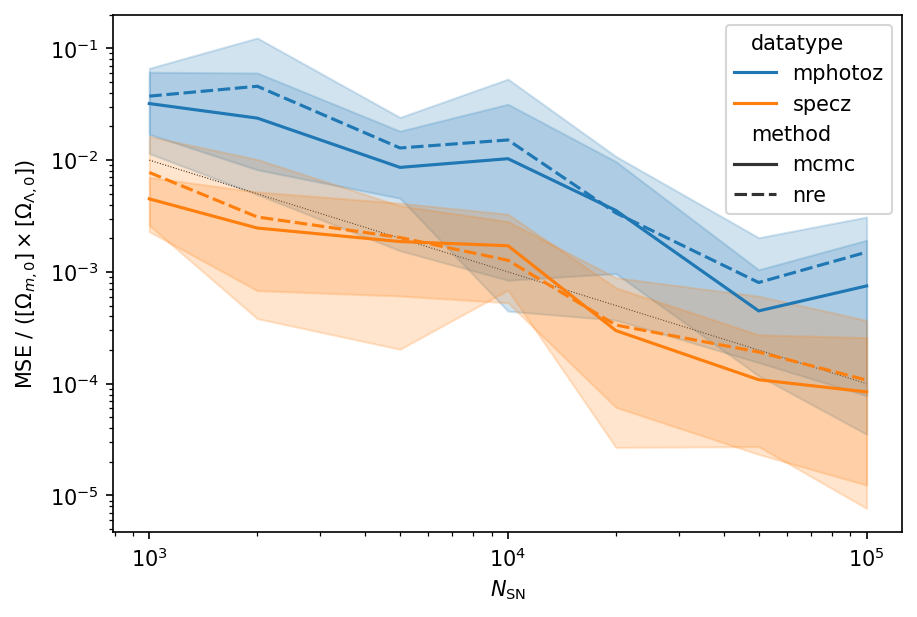

In [81]:
sns.lineplot(
    # data=(mses['detcov']**(1/2)).reset_index(), x='N', y='detcov',
    data=(mses['bias']**2).reset_index(), x='N', y='bias',
    # data=mses.reset_index(), x='N', y='bias',
    hue='datatype', style='method', #row='level',
    ci=100,
).set(yscale='log', xscale='log', xlabel='$N_{\mathrm{SN}}$', ylabel=r'MSE / $([\Omega_{m, 0}] \times [\Omega_{\Lambda, 0}])$')
annotate(None)

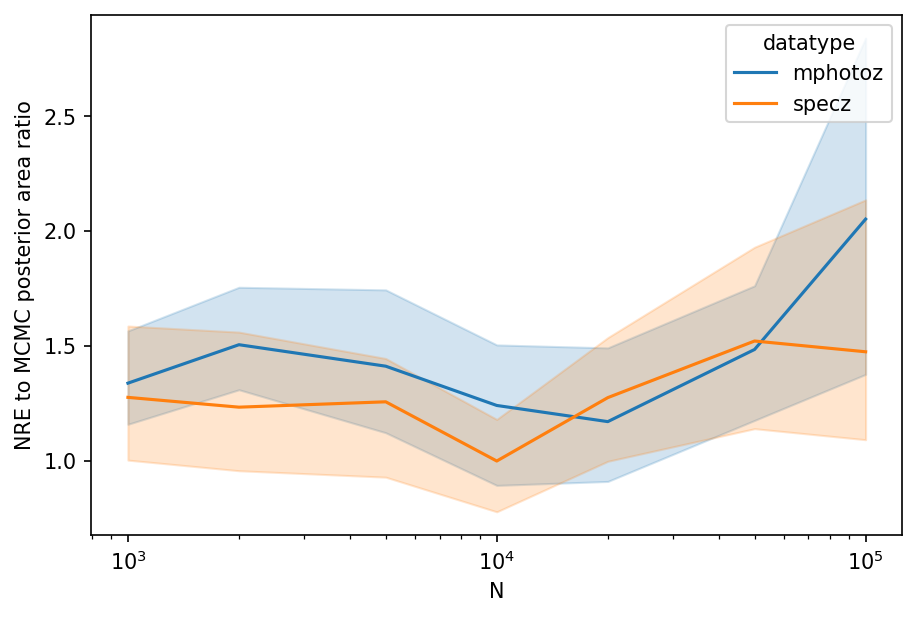

In [108]:
sns.lineplot(
    data=(mses['nre'] / mses['mcmc']).rename('ratio').reset_index(), x='N', y='ratio',
    hue='datatype',
    ci=100,
).set(xscale='log', ylabel='NRE to MCMC posterior area ratio');

#### TiKZ

In [78]:
TABLE = mses
funcs = np.mean, min, max

dta = TABLE.reset_index().drop(columns='version').groupby([n for n in TABLE.index.names if n not in ('version',)]).aggregate(funcs)

dta = pd.concat({
    'mcmc': dta.loc['mcmc'], 'nre': dta.loc['nre'],
    'ratio': (TABLE.loc['nre'] / TABLE.loc['mcmc']).reset_index().drop(columns='version').groupby([n for n in TABLE.index.names if n not in ('version', 'method')]).aggregate(funcs)
}, axis='columns')

dta.columns = dta.columns.to_flat_index()
dta = dta.rename(columns=' '.join)
dta.to_csv('paper/plotdata/nre_mc-sizes.csv')
dta

mcmc detcov mean  mcmc detcov min  mcmc detcov max  \
N      datatype                                                       
1000   mphotoz       1.476216e-04     9.412276e-05     1.984392e-04   
       specz         3.966414e-06     3.198936e-06     5.203376e-06   
2000   mphotoz       4.775611e-05     2.921013e-05     6.448523e-05   
       specz         1.252942e-06     1.034478e-06     1.496950e-06   
5000   mphotoz       6.019897e-06     4.197408e-06     8.554893e-06   
       specz         1.405309e-07     1.303174e-07     1.646754e-07   
10000  mphotoz       2.040072e-06     1.297972e-06     2.828284e-06   
       specz         4.239869e-08     3.669033e-08     5.030112e-08   
20000  mphotoz       5.355429e-07     3.928080e-07     6.780253e-07   
       specz         1.084733e-08     9.521526e-09     1.285071e-08   
50000  mphotoz       7.433194e-08     6.832521e-08     8.436049e-08   
       specz         1.707396e-09     1.622995e-09     1.844676e-09   
100000 mphotoz       1.772863e-08     1.612474e-08     2.001121e-08   
       specz         4.028779e-10     3.640944e-10     4.437938e-10   

                 mcmc bias mean  mcmc bias min  mcmc bias max  mcmc mse mean  \
N      datatype                                                                
1000   mphotoz         0.164469       0.057733       0.278142       0.088296   
       specz           0.064663       0.025556       0.088135       0.014233   
2000   mphotoz         0.128344       0.012569       0.326532       0.060401   
       specz           0.041011       0.002930       0.088976       0.007949   
5000   mphotoz         0.080113       0.008258       0.166349       0.020963   
       specz           0.035499       0.002914       0.080821       0.003647   
10000  mphotoz         0.074522       0.006455       0.242654       0.018165   
       specz           0.038257       0.015903       0.063778       0.002756   
20000  mphotoz         0.049690       0.001031       0.131127       0.007509   
       specz           0.013452       0.003421       0.034088       0.000827   
50000  mphotoz         0.018232       0.004011       0.044837       0.001877   
       specz           0.008889       0.002741       0.021260       0.000314   
100000 mphotoz         0.020476       0.001865       0.054414       0.001443   
       specz           0.006640       0.000733       0.024107       0.000184   

                 mcmc mse min  mcmc mse max  nre detcov mean  ...  \
N      datatype                                               ...   
1000   mphotoz       0.047376      0.135387     2.531754e-04  ...   
       specz         0.011459      0.017330     5.534127e-06  ...   
2000   mphotoz       0.036593      0.145234     8.177288e-05  ...   
       specz         0.005228      0.012939     2.072739e-06  ...   
5000   mphotoz       0.011641      0.042991     1.008266e-05  ...   
       specz         0.001721      0.008262     2.429928e-07  ...   
10000  mphotoz       0.006782      0.068955     3.814679e-06  ...   
       specz         0.001239      0.005044     7.946805e-08  ...   
20000  mphotoz       0.003927      0.021955     9.703617e-07  ...   
       specz         0.000536      0.001671     2.222906e-08  ...   
50000  mphotoz       0.001289      0.003532     1.554320e-07  ...   
       specz         0.000211      0.000652     3.826144e-09  ...   
100000 mphotoz       0.000655      0.003733     4.610440e-08  ...   
       specz         0.000098      0.000685     9.391590e-10  ...   

                 nre mse max  ratio detcov mean  ratio detcov min  \
N      datatype                                                     
1000   mphotoz      0.165425           1.770425          1.363903   
       specz        0.033030           1.411698          1.106382   
2000   mphotoz      0.261257           1.725749          1.057768   
       specz        0.024791           1.660948          1.402971   
5000   mphotoz      0.049067           1.659363          1.270125   
       spec

## Photoz

Text(0.5, 0.98, '90% posterior credibility: TMNRE (full model) vs MCMC (simplified)')

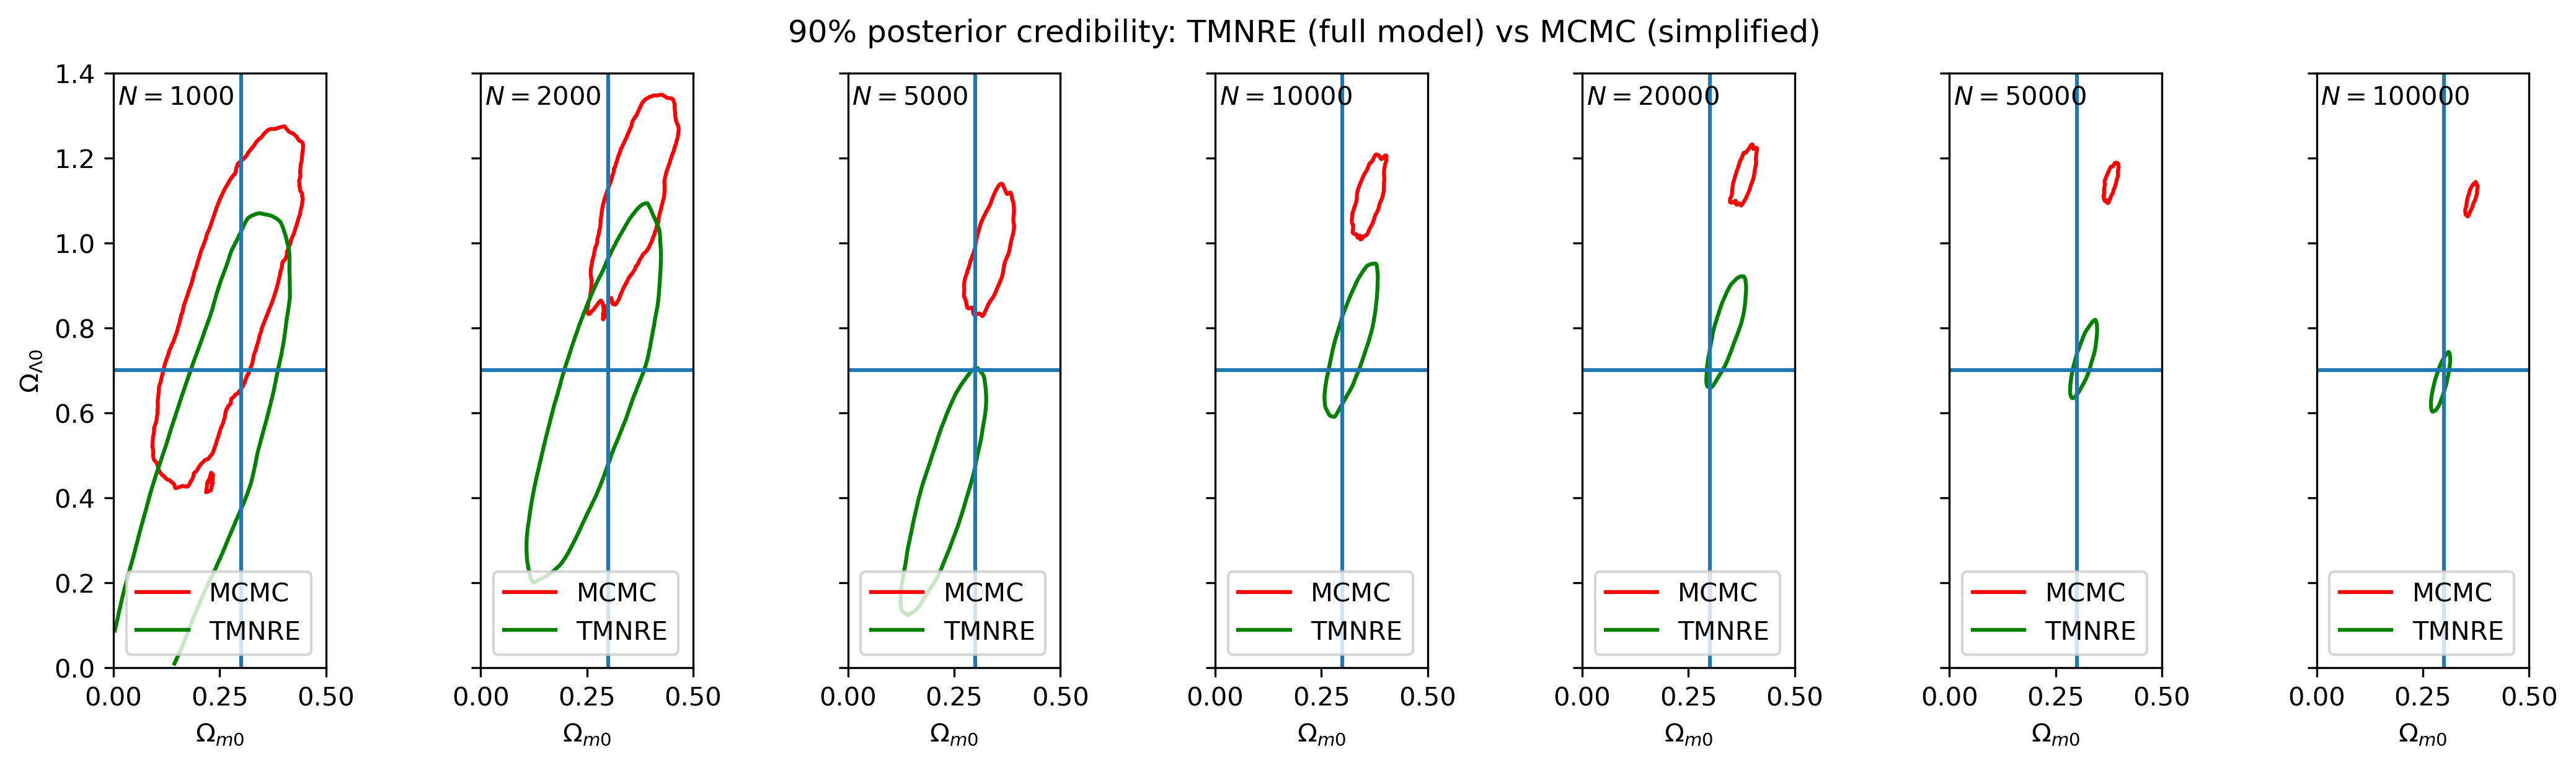

In [3]:
LEVELS = 0.9,

hdis_ = hdis.xs(axis='index', level='suffix', key=0).xs(axis='index', level='datatype', key='photoz').xs(axis='index', level='version', key=0)
fig, axs = plt.subplots(1, len(hdis_), sharex='all', sharey='all', dpi=300, figsize=(len(hdis_)*2, 4))

for ax, (N, row) in zip(axs, hdis_.iterrows()):
    ax.tricontour(*row['mcmc'], levels=LEVELS, colors='red')
    if not pd.isna(row['nre']):
        ax.tricontour(*row['nre'], levels=LEVELS, colors='green')

    ax.axhline(0.7)
    ax.axvline(0.3)
    ax.set_aspect('equal')

    ax.text(0.02, 0.98, f'$N = {N}$', transform=ax.transAxes, va='top', ha='left')
    ax.set_xlabel('$\Omega_{m 0}$')
    ax.legend(handles=[plt.Line2D([], [], color='red', label='MCMC'),
                       plt.Line2D([], [], color='green', label='TMNRE')],
              loc='lower left')

axs[0].set_ylabel('$\Omega_{\Lambda 0}$')
plt.xlim(0, 0.5)
plt.ylim(0, 1.4)

plt.suptitle('90% posterior credibility: TMNRE (full model) vs MCMC (simplified)')

#### TiKZ

In [4]:
levels = 0.68, 0.9, 0.95

res = {
    method: {
        '/'.join(map(str, keys)): {
            int(100*level): segs_to_coords(segs)
            for level, segs in zip(levels, plt.tricontour(*hdi, levels=levels).allsegs)
            for _ in [print(method, keys, level)]
        } for keys, hdi in hdis_.items() if not pd.isna(hdi)
    } for method, hdis_ in hdis.items()
}
plt.close()

mcmc (1000, 'mphotoz', 0, 0) 0.68
mcmc (1000, 'mphotoz', 0, 0) 0.9
mcmc (1000, 'mphotoz', 0, 0) 0.95
mcmc (1000, 'mphotoz', 0, 1) 0.68
mcmc (1000, 'mphotoz', 0, 1) 0.9
mcmc (1000, 'mphotoz', 0, 1) 0.95
mcmc (1000, 'mphotoz', 0, 2) 0.68
mcmc (1000, 'mphotoz', 0, 2) 0.9
mcmc (1000, 'mphotoz', 0, 2) 0.95
mcmc (1000, 'mphotoz', 0, 3) 0.68
mcmc (1000, 'mphotoz', 0, 3) 0.9
mcmc (1000, 'mphotoz', 0, 3) 0.95
mcmc (1000, 'mphotoz', 0, 4) 0.68
mcmc (1000, 'mphotoz', 0, 4) 0.9
mcmc (1000, 'mphotoz', 0, 4) 0.95
mcmc (1000, 'mphotoz', 0, 5) 0.68
mcmc (1000, 'mphotoz', 0, 5) 0.9
mcmc (1000, 'mphotoz', 0, 5) 0.95
mcmc (1000, 'mphotoz', 0, 6) 0.68
mcmc (1000, 'mphotoz', 0, 6) 0.9
mcmc (1000, 'mphotoz', 0, 6) 0.95
mcmc (1000, 'mphotoz', 0, 7) 0.68
mcmc (1000, 'mphotoz', 0, 7) 0.9
mcmc (1000, 'mphotoz', 0, 7) 0.95
mcmc (1000, 'mphotoz', 0, 8) 0.68
mcmc (1000, 'mphotoz', 0, 8) 0.9
mcmc (1000, 'mphotoz', 0, 8) 0.95
mcmc (1000, 'mphotoz', 0, 9) 0.68
mcmc (1000, 'mphotoz', 0, 9) 0.9
mcmc (1000, 'mphotoz', 0

In [5]:
open('paper/plotdata/nre_mc.tex', 'w').write('\n'.join(map(str, (
    to_pgfdata(res, namespace='private/nre_mc'),
))))

11563707